# RNA velocity
author: Guangxin Zhang

This learning note synthesizes findings from La Manno et al.'s research published in Nature (2018) and Bergen et al.'s work in Nature Biotechnology (2020) to offer a thorough overview. For detailed calculations, please consult the respective articles. Additionally, the demonstration work cited in this note can be found at https://scvelo.readthedocs.io/en/stable/index.html.

Feel free to redistribute with credit.

## An overview of RNA velocity

The original verision based on an ordinary differential equation model of transcription and the assumption that the relationship between spliced mRNA expression and unspliced pre-mRNA expression can be used to infer whether a gene is in the process of being upregulated or downregulated or in a steady expression state(Under an assumption of constant rates):

<div style="text-align: center;">
    <img src="./pic/principle.png" alt="image" style="width: 10%;"/>
</div>


$$
\frac{du(t)}{dt} = \alpha^{(k)} - \beta u(t).
$$

$$
\frac{ds(t)}{dt} = \beta u(t) - \gamma s(t).
$$

There are three unknown (constant) parameters for each gene: the transcription rate ($\alpha $
), the splicing rate ($\beta $
), and the degradation rate ($\gamma $). 

The time derivative
of mature spliced mRNA, termed RNA velocity, is denoted as: $v(t)=\frac{ds(t)}{dt}$  






## Steady-state model 

Under the assumption that we observe both transcriptional
phases of induction and repression, and that these phases last sufficiently long to
reach a transcribing (active) and a silenced (inactive) steady-state equilibrium,
velocity estimation can be simplified.

On average, when it reaches $\frac{ds}{dt}=0$, yielding $\gamma '=\frac{u(t)}{s(t)}=\frac{\gamma}{\beta}$ 



Steady states are expected
at the lower and upper quantiles in phase space, that is, where mRNA levels
reach minimum and maximum expression, respectively. This is because:

Lower Quantiles: At minimal expression levels, cells are likely in a silenced state where transcriptional induction is minimal or absent, leading to low rates of both unspliced and spliced mRNA synthesis. Here, the degradation rates catch up with the slow synthesis rates, creating a balance or steady state.

Upper Quantiles: At maximum expression levels, cells are in a highly active transcriptional phase, with high rates of mRNA synthesis. Over time, degradation processes also intensify to match the high synthesis rates, again leading to a new equilibrium or steady state.

Hence, the ratio can be
approximated by a linear regression on these extreme quantiles.It can be solved analytically via a least square fit and is given by:

$\gamma '=\frac{u^{T}s(t)}{||s||^{2}}$ 

where $u=(u_1,...,u_n)$
and $s=(s_1,...,s_n)$
are vectors of size-normalized unspliced
and spliced counts.

Then, velocities can be computed as deviations from this steady-state ratio:

$v_i=u_i-\gamma ' s_i$

Challenges:

* Equilibrium Assumption: It assumes mRNA synthesis and degradation are balanced, potentially missing the complex, dynamic nature of cellular processes.
* Latent Time Estimation: By avoiding direct estimation of the actual timing of cellular states, it may not accurately reflect the progression of biological processes or transient cellular states.
* Simplification of Kinetic Rates: The model relies on the ratio of unspliced to spliced mRNA, assuming a uniform splicing rate across all genes. This simplification can lead to inaccuracies, as splicing rates vary among genes and are crucial for gene expression regulation.
* Oversimplification Issues: Assuming a common splicing rate for all genes oversimplifies the complexity of transcriptional and post-transcriptional regulation, potentially overlooking important aspects of gene expression dynamics.


## Dynamical model

In recognition that steady states are not
always captured and that splicing rates differ between genes, a
framework that does not rely on these restrictions is established. 


$$
u(t) = u_0 e^{-\beta t} + \frac{\alpha^{(k)}}{\beta} \left(1 - e^{-\beta t}\right)
$$

$$
s(t) = s_0 e^{-\gamma t} + \frac{\alpha^{(k)}}{\gamma} \left(1 - e^{-\gamma t}\right)
+ \frac{\alpha^{(k)} - \beta u_0 \left(e^{-\gamma t} - e^{-\beta t}\right)}{\gamma - \beta}
$$

$$
\tau = t - t^{(k)}_0
$$

In a model of gene regulation, the rates of reaction are defined by parameters $\Theta = (\alpha^{(k)}, \beta, \gamma)$, with each cell having specific time points $t \in (t_1, \ldots, t_N)$ and initial states for unspliced $u_0 = u(t_0)$ and spliced $s_0 = s(t_0)$ RNAs.

Transcriptional regulation dictates gene activity, meaning that any increase or decrease in gene expression is a result of changes in the transcription rate $\alpha^{(k)}$, which is dependent on the cell's state. This rate isn't constant; it can have several configurations, representing different transcriptional states. Thus, each cell is assigned a specific transcriptional state $k$, which influences not just $\alpha^{(k)}$ but also the initial conditions $u_0^{(k)}, s_0^{(k)}$, and the timing $t_0^{(k)}$ at which the cell transitions between states.

They explore four main phases in this context: induction ($k = 1$) and repression ($k = 0$), each linked to a potential steady state ($k = ss$ and $k = ss_0$). As a cell moves from one state $k$ to another state $k'$, like from active gene expression to repression, we determine the initial conditions for the new state by examining the path of the cell at the point it switches states.


$$
u_0^{(k)} = u \left( t_0^{(k)} | \theta^{(k)}\right) ,
$$
$$
s_0^{(k)} = s \left( t_0^{(k)} | \theta^{(k)}\right) ,
$$



Where $t_0^{(k)}$ is learned jointly with the parameters of reaction rates, as will be described later.





Being at state $k$, abundances can potentially reach their steady state in the limit

$$
(u_{\infty}^{(k)}, s_{\infty}^{(k)}) = \left( \frac{\alpha^{(k)}}{\beta} , \frac{\alpha^{(k)}}{\gamma} \right) .
$$

The number of potential steady states equals the number of transcriptional states.





The equations above hold for a single gene. Across all genes, the same equations hold under the
same assumptions, but with gene-specific rate constants.




## RNA Velocity Basics

In [134]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet

import scvelo as scv
scv.logging.print_version()

Running scvelo 0.3.2 (python 3.10.13) on 2024-04-05 14:06.


The analysis is based on the in-built pancreas data. To run velocity analysis on your own data, read your file (loom, h5ad, csv …) to an AnnData object with adata = scv.read('path/file.loom', cache=True). If you want to merge your loom file into an already existing AnnData object, use scv.utils.merge(adata, adata_loom).

In [135]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [136]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

The structure of adata:<div style="text-align: center;">
    <img src="./pic/data.png" alt="image" style="width: 40%;"/>
</div>


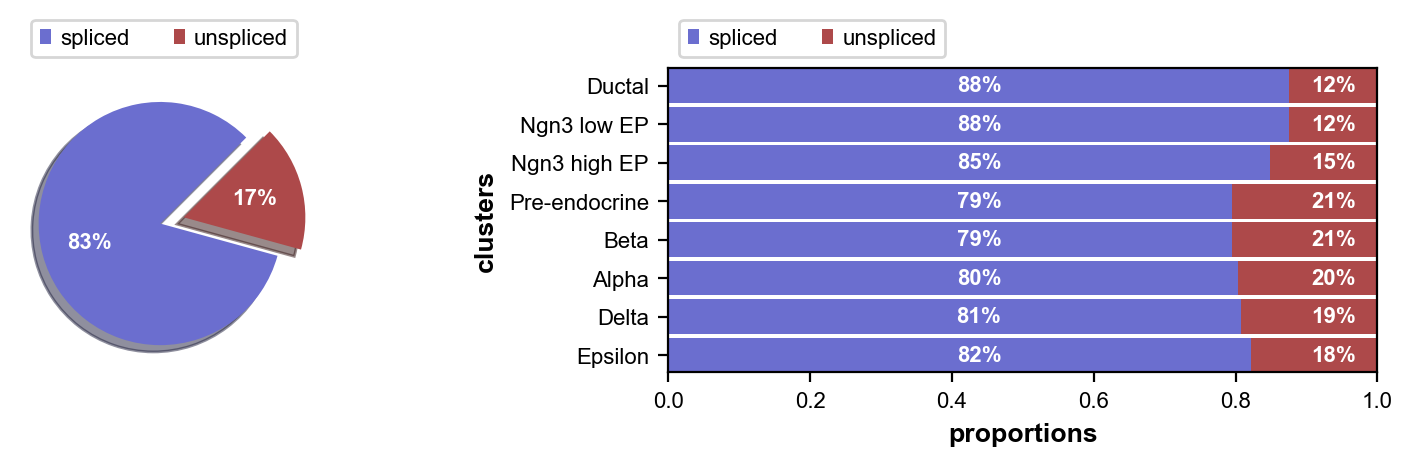

In [137]:
scv.pl.proportions(adata)

Depending on the protocol used (Drop-Seq, Smart-Seq), we typically have between 10%-25% of unspliced molecules containing intronic sequences. We also advice you to examine the variations on cluster level to verify consistency in splicing efficiency. Here, we find variations as expected, with slightly lower unspliced proportions at cycling ductal cells, then higher proportion at cell fate commitment in Ngn3-high and Pre-endocrine cells where many genes start to be transcribed.

## Preprocess the Data

Preprocessing requisites consist of gene selection by detection (with a minimum number of counts) and high variability (dispersion), normalizing every cell by its total size and logarithmizing X. Filtering and normalization is applied in the same vein to spliced/unspliced counts and X. Logarithmizing is only applied to X. If X is already preprocessed from former analysis, it will not be touched.

All of this is summarized in a single function scv.pp.filter_and_normalize, which essentially runs the following:

In [138]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


C:\Users\zgx\AppData\Local\Temp\ipykernel_27240\2386943043.py:4: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Further, we need the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA space, summarized in scv.pp.moments, which internally computes scv.pp.pca and scv.pp.neighbors. First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [139]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Estimate RNA velocity

Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default) or deterministically (by setting mode='deterministic'). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

The solution to the full dynamical model is obtained by setting mode='dynamical', which requires to run scv.tl.recover_dynamics(adata) beforehand. 

In [140]:
scv.tl.velocity(adata)

computing velocities


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The computed velocities are stored in adata.layers just like the count matrices.

The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension nobs×nobs
 and summarizes the possible cell state changes that are well explained through the velocity vectors (for runtime speedup it can also be computed on reduced PCA space by setting approx=True).

In [141]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/20 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


For a variety of applications, the velocity graph can be converted to a transition matrix by applying a Gaussian kernel to transform the cosine correlations into actual transition probabilities. You can access the Markov transition matrix via scv.utils.get_transition_matrix.

As mentioned, it is internally used to project the velocities into a low-dimensional embedding by applying the mean transition with respect to the transition probabilities, obtained with scv.tl.velocity_embedding. Further, we can trace cells along the Markov chain to their origins and potential fates, thereby getting root cells and end points within a trajectory, obtained via scv.tl.terminal_states.

## Project the velocities

Finally, the velocities are projected onto any embedding, specified by basis, and visualized in one of these ways: 

- on cellular level with scv.pl.velocity_embedding, 
- as gridlines with scv.pl.velocity_embedding_grid, 
- or as streamlines with scv.pl.velocity_embedding_stream.

Note, that the data has an already pre-computed UMAP embedding, and annotated clusters. When applying to your own data, these can be obtained with scv.tl.umap and scv.tl.louvain. For more details, see the scanpy tutorial. Further, all plotting functions are defaulted to using basis='umap' and color='clusters', which you can set accordingly.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

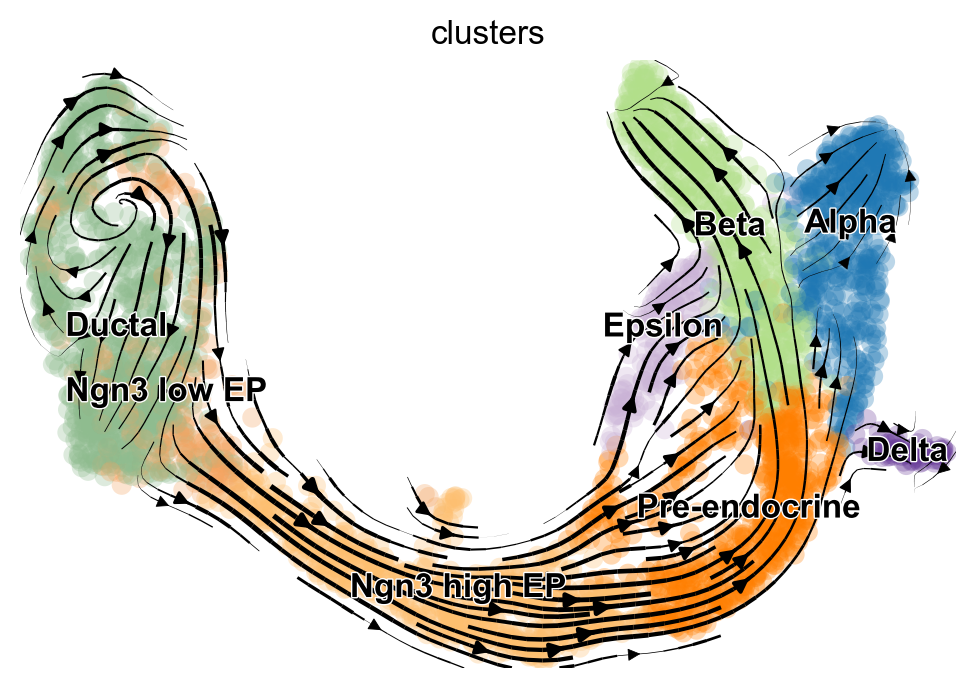

In [142]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation.

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

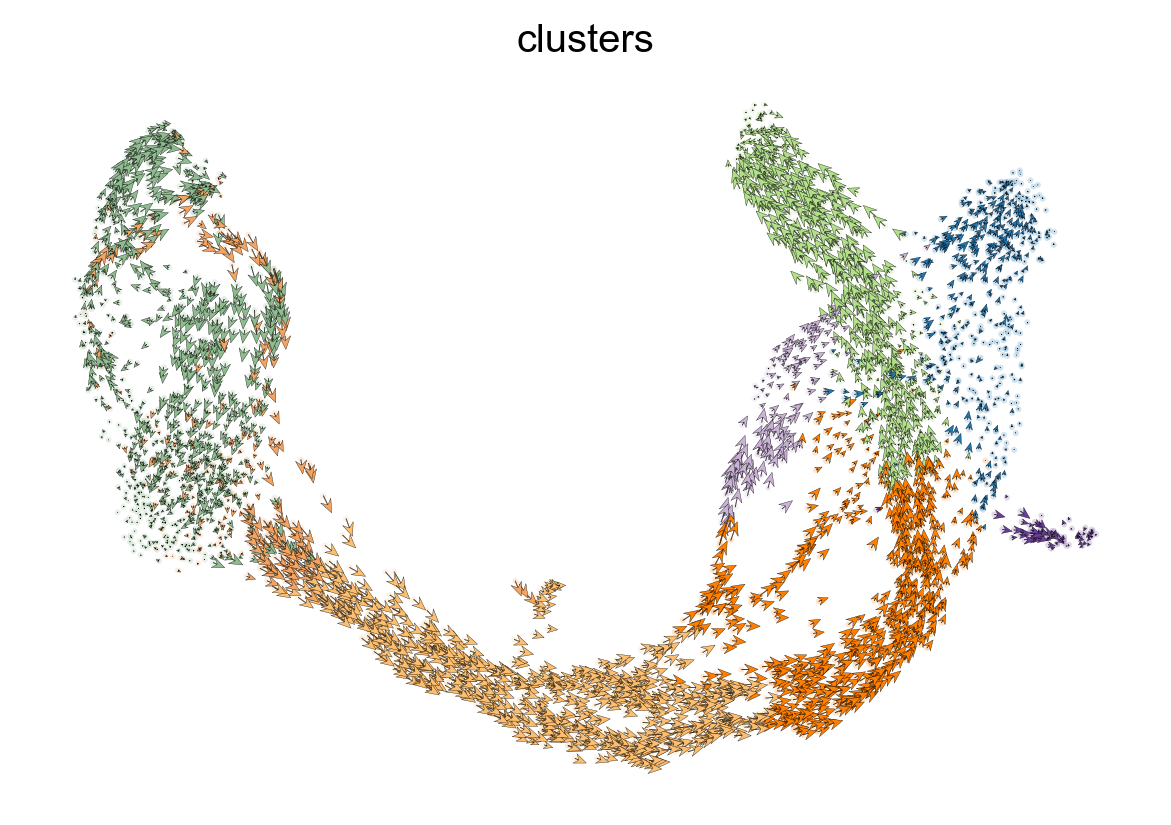

In [143]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

## Interprete the velocities

This is perhaps the most important part as we advise the user not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes.
<div style="text-align: center;">
    <img src="./pic/1.gif" alt="image" style="width: 40%;"/>
</div>

See the gif here to get an idea of how to interpret a spliced vs. unspliced phase portrait. Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait.

Now, let us examine the phase portraits of some marker genes, visualized with scv.pl.velocity(adata, gene_names) or scv.pl.scatter(adata, gene_names).

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

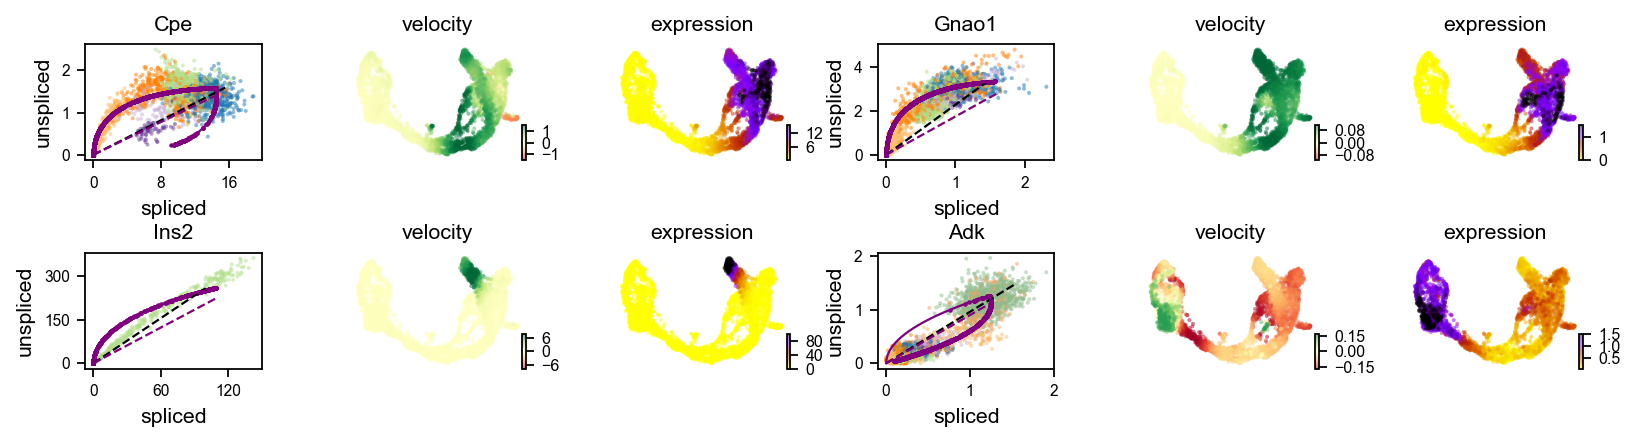

In [169]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

The black line corresponds to the estimated ‘steady-state’ ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

For instance Cpe explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while Adk explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

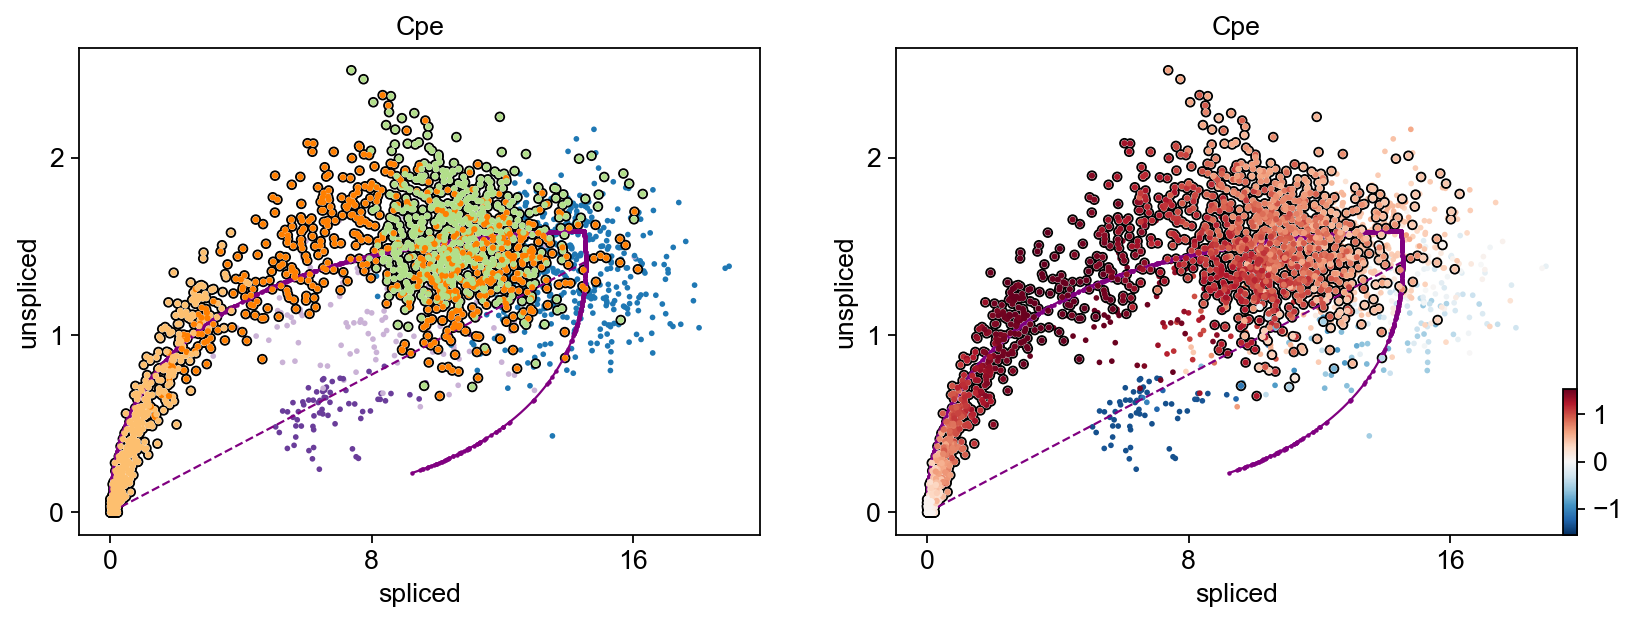

In [168]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

## Identify important genes

We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [144]:
import pandas as pd

scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\tools\utils.py:463: DeprecationWarning: Please import `rankdata` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0  Notch2       Ptpn3        Pde1c           Pam     Pax6  Zcchc16    Zdbf2   
1    Sox5       Hacd1        Ptprs          Sdk1    Unc5c    Nlgn1   Spock3   
2   Krt19       Hspa8         Pclo        Baiap3     Nnat   Prune2  Akr1c19   
3   Hspa8      Gm8113     Rap1gap2         Abcc8  Tmem108     Ksr2    Ptprt   
4    Ano6       Kcnq1        Ttyh2          Gnas    Ptprt    Chrm3   Snap25   

  Epsilon  
0   Tmcc3  
1    Heg1  
2  Gpr179  
3    Ica1  
4   Ncoa7

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

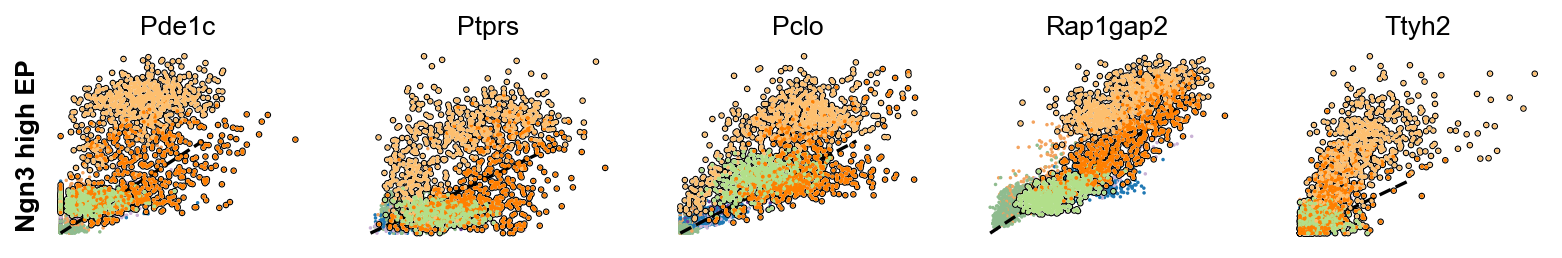

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

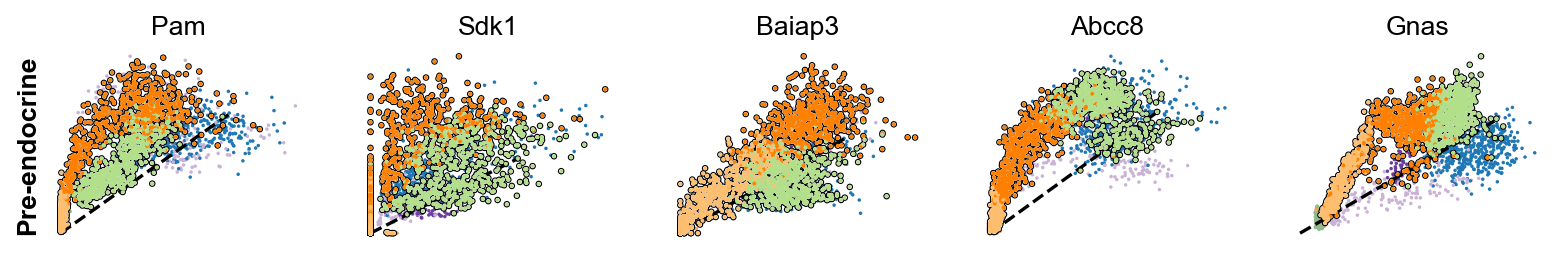

In [145]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

The genes Ptprs, Pclo, Pam, Abcc8, Gnas, for instance, support the directionality from Ngn3 high EP (yellow) to Pre-endocrine (orange) to Beta (green).

## Velocities in cycling progenitors

The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

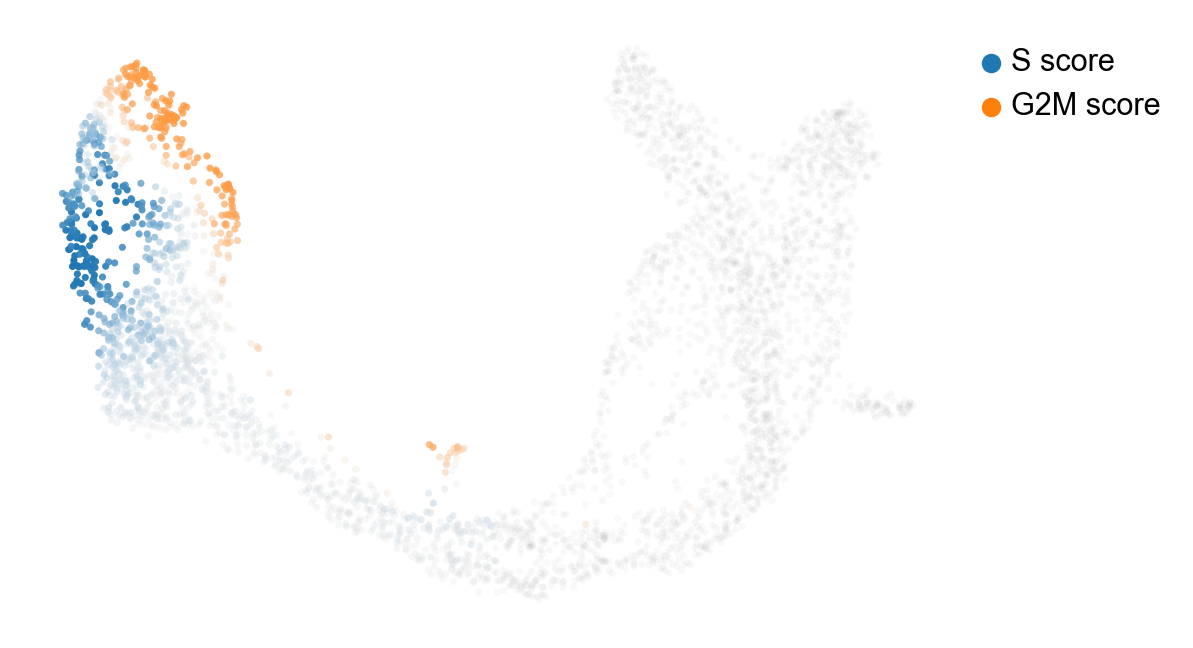

In [146]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

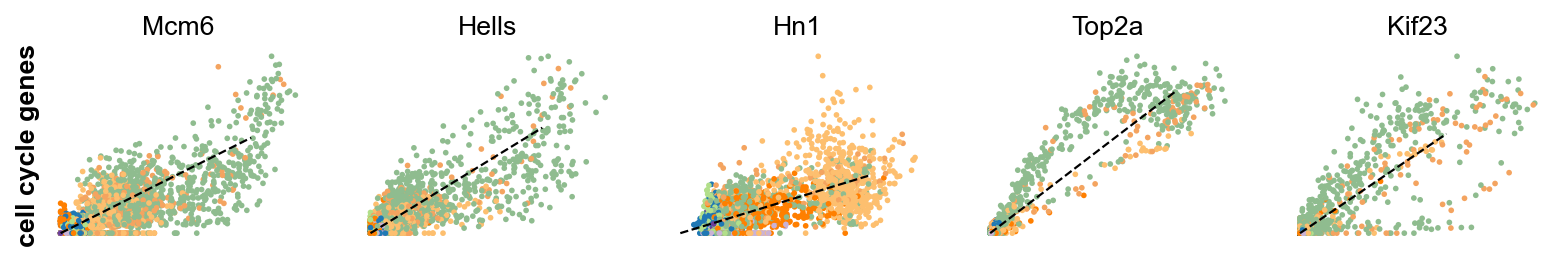

In [147]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

Particularly Hells and Top2a are well-suited to explain the vector field in the cycling progenitors. Top2a gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

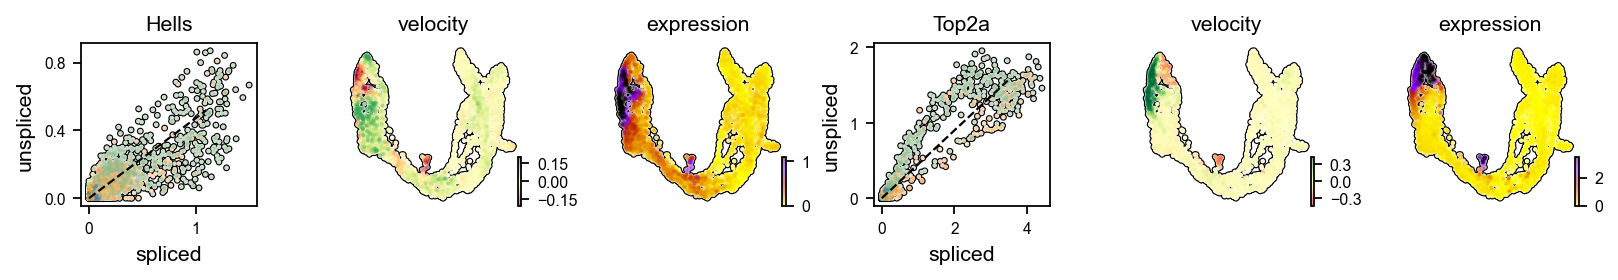

In [148]:
scv.pl.velocity(adata, ['Hells', 'Top2a'], ncols=2, add_outline=True)

## Speed and coherence

Two more useful stats: 

* The speed or rate of differentiation is given by the length of the velocity vector. 
* The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

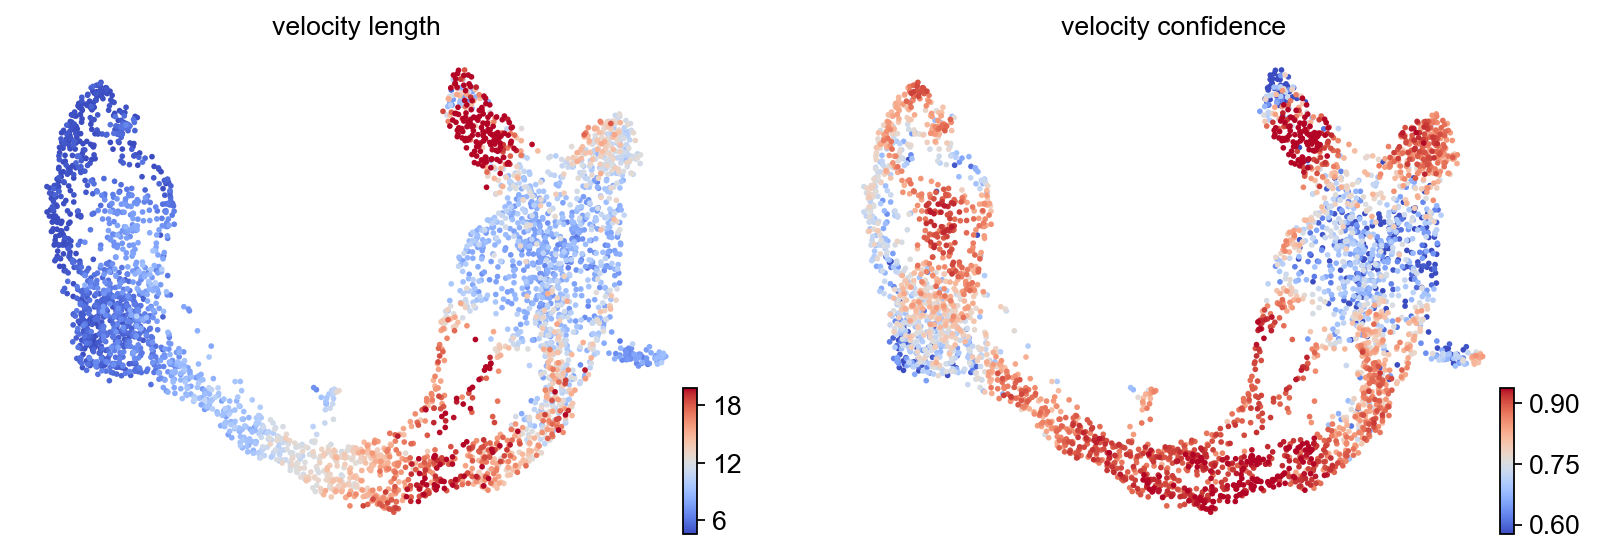

In [149]:
scv.tl.velocity_confidence(adata)
keys = ['velocity_length', 'velocity_confidence']
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

On cluster-level, we find that differentiation substantially speeds up after cell cycle exit (Ngn3 low EP), keeping the pace during Beta cell production while slowing down during Alpha cell production.

In [150]:
df = adata.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

## Velocity graph and pseudotime

We can visualize the velocity graph to portray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a threshold. The graph, for instance, indicates two phases of Epsilon cell production, coming from early and late Pre-endocrine cells.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

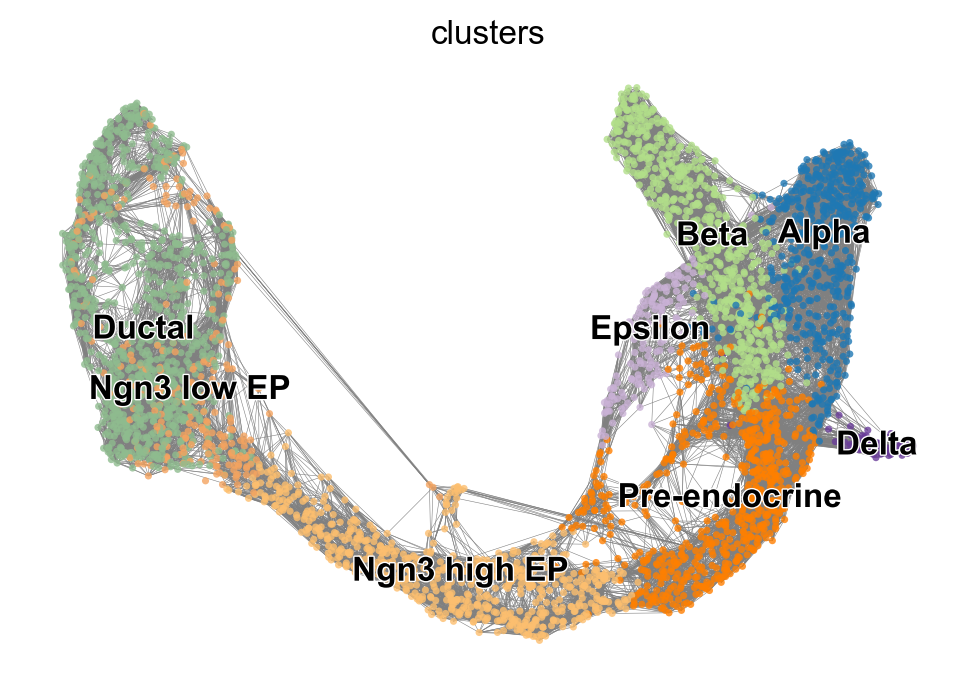

In [151]:
scv.pl.velocity_graph(adata, threshold=.1)

Further, the graph can be used to draw descendents/anscestors coming from a specified cell. Here, a pre-endocrine cell is traced to its potential fate.

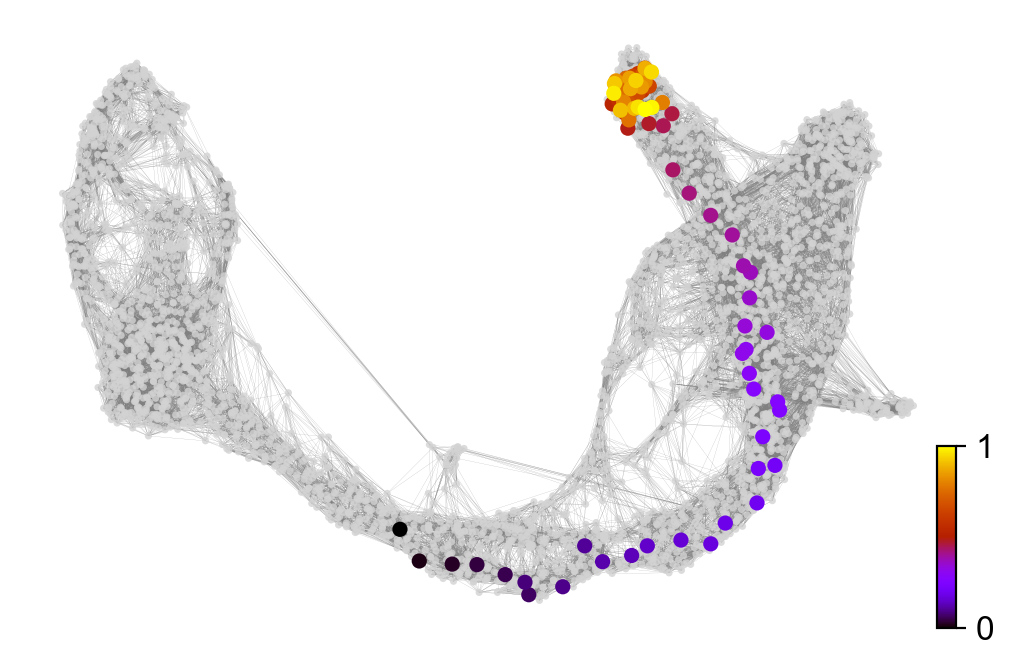

In [152]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

Finally, based on the velocity graph, a velocity pseudotime can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells.

Contrarily to diffusion pseudotime, it implicitly infers the root cells and is based on the directed velocity graph instead of the similarity-based diffusion kernel.

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

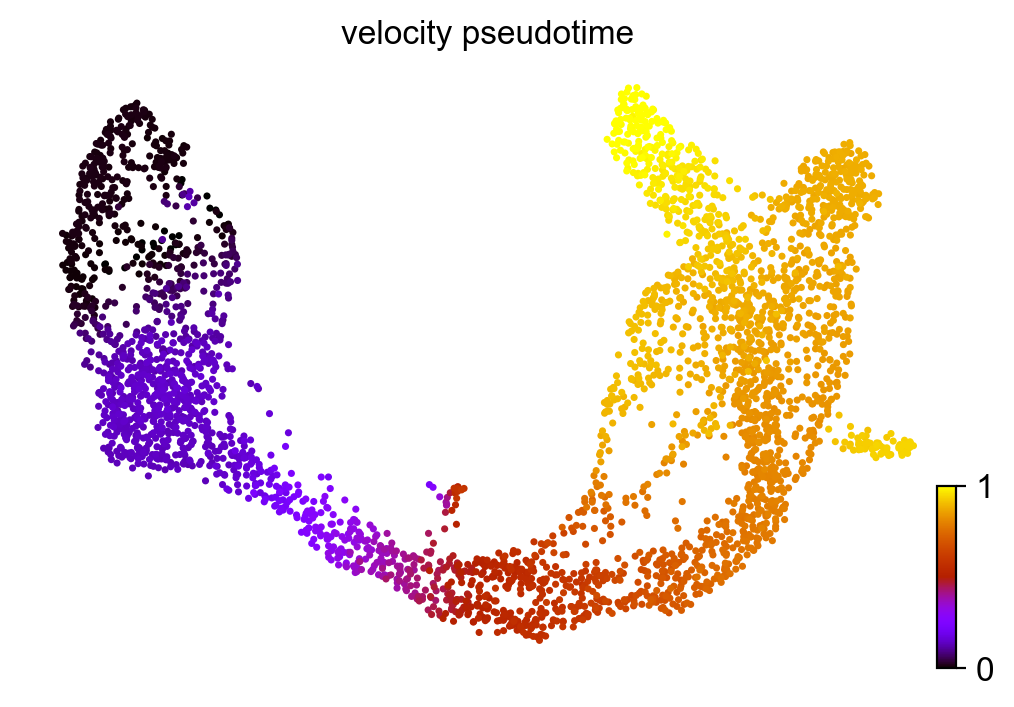

In [153]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

## PAGA velocity graph

PAGA graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. Here, PAGA is extended by velocity-inferred directionality.

In [154]:
# PAGA requires to install igraph, if not done yet.
!pip install python-igraph --upgrade --quiet

In [155]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')
    

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\core\_anndata.py:245: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(data.obs[key])


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP.

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

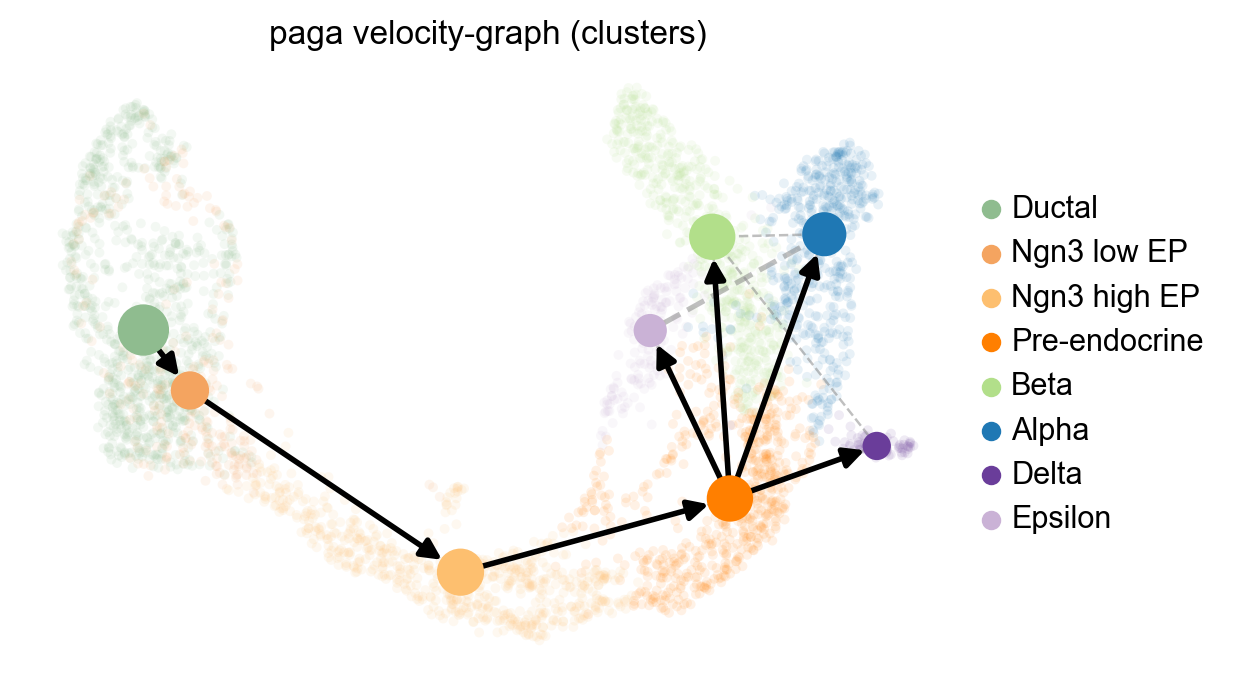

In [156]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

# Dynamical Model

We run the dynamical model to learn the full transcriptional dynamics of splicing kinetics.

It is solved in a likelihood-based expectation-maximization framework, by iteratively estimating the parameters of reaction rates and latent cell-specific variables, i.e. transcriptional state and cell-internal latent time. It thereby aims to learn the unspliced/spliced phase trajectory for each gene.

In [157]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/20 cores)


  0%|          | 0/1020 [00:00<?, ?gene/s]

    finished (0:06:23) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [158]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Running the dynamical model can take a while. Hence, you may want to store the results for re-use, with adata.write('data/pancreas.h5ad', which can later be read with adata = scv.read('data/pancreas.h5ad').

In [159]:
adata.write('data/pancreas.h5ad', compression='gzip')
adata = scv.read('data/pancreas.h5ad')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

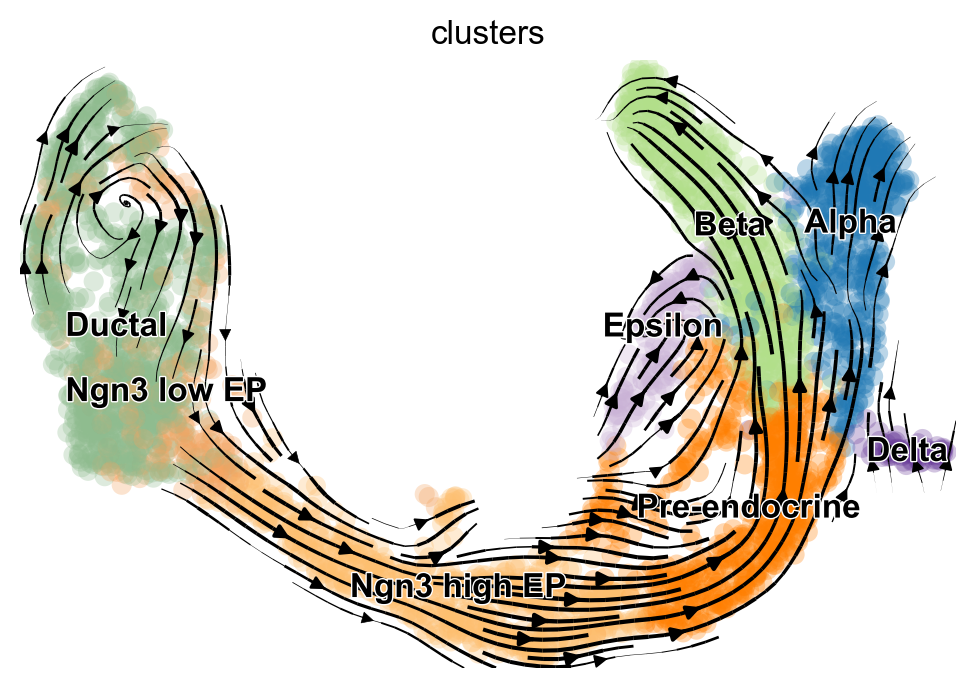

In [160]:
scv.pl.velocity_embedding_stream(adata, basis='umap')


## Kinetic rate paramters

The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data.
They can be useful to better understand the cell identity and phenotypic heterogeneity.

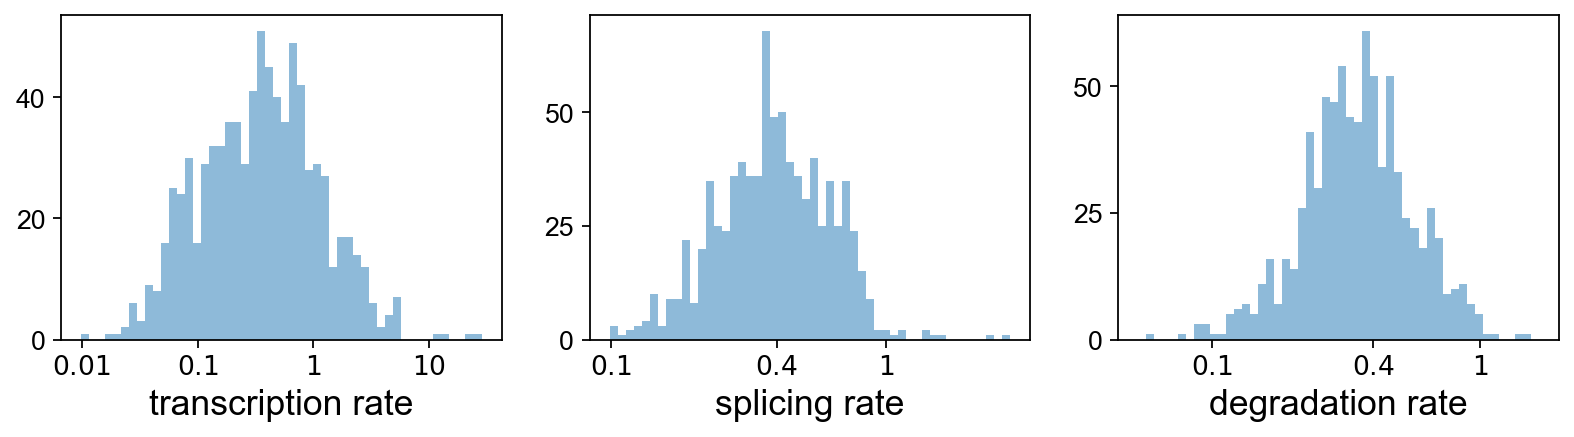

fit_alpha  fit_beta  fit_gamma  fit_t_  fit_scaling  fit_std_u  \
index                                                                     
Sntg1         0.02  5.59e-03       0.09   23.40        42.85       1.03   
Sbspon        0.46  2.44e+00       0.38    3.79         0.15       0.06   
Mcm3          3.10  4.00e+01       0.64    2.05         0.01       0.02   
Fam135a       0.17  1.18e-01       0.20   11.24         1.12       0.36   
Adgrb3        0.05  6.75e-03       0.20    6.99        71.85       2.15   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
index                                                                 
Sntg1         0.03            0.41     0.0     0.0             0.16   
Sbspon        0.18            0.25     0.0     0.0             0.18   
Mcm3          0.67            0.23     0.0     0.0             0.47   
Fam135a       0.15            0.28     0.0     0.0             0.39   
Adgrb3        0.03            0.25     0.0     0.0             0.07   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
index                                                                      
Sntg1            2.47          0.09          0.15                   5.36   
Sbspon           0.16          0.43          0.67                   1.19   
Mcm3             0.05          1.93          0.69                   0.89   
Fam135a          1.35          0.39          0.67                   3.39   
Adgrb3           5.21          0.09          0.56                   1.89   

         fit_r2  
index            
Sntg1      0.40  
Sbspon     0.62  
Mcm3       0.29  
Fam135a    0.38  
Adgrb3     0.38

In [161]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

The estimated gene-specific parameters comprise rates of transription (fit_alpha), splicing (fit_beta), degradation (fit_gamma), switching time point (fit_t_), a scaling parameter to adjust for under-represented unspliced reads (fit_scaling), standard deviation of unspliced and spliced reads (fit_std_u, fit_std_s), the gene likelihood (fit_likelihood), inferred steady-state levels (fit_steady_u, fit_steady_s) with their corresponding p-values (fit_pval_steady_u, fit_pval_steady_s), the overall model variance (fit_variance), and a scaling factor to align the gene-wise latent times to a universal, gene-shared latent time (fit_alignment_scaling).

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

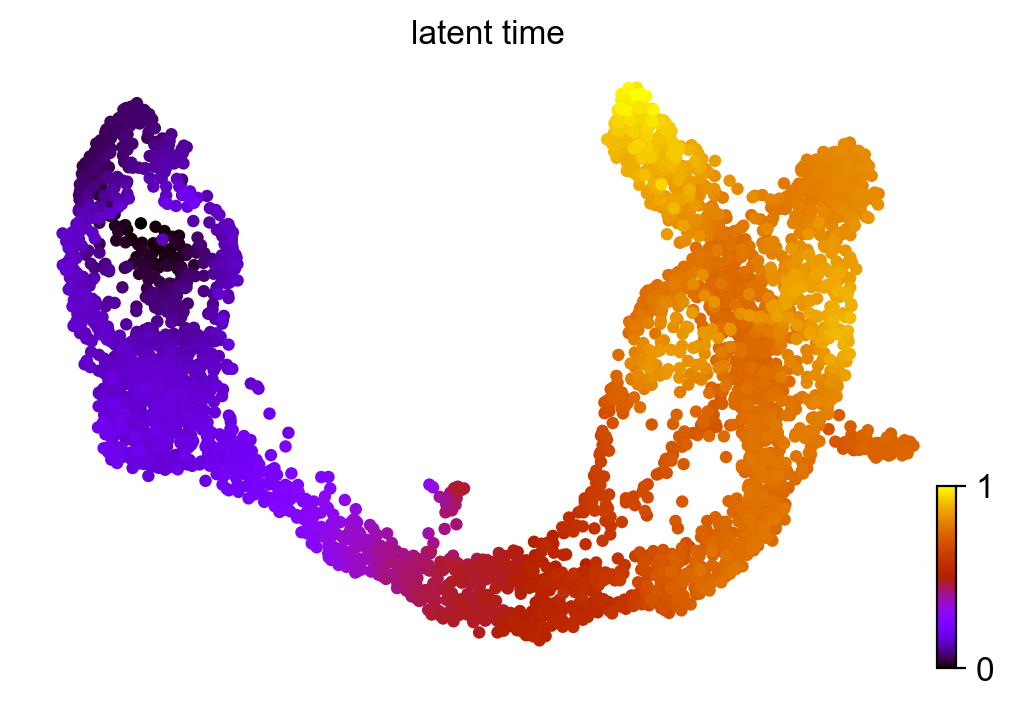

In [162]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


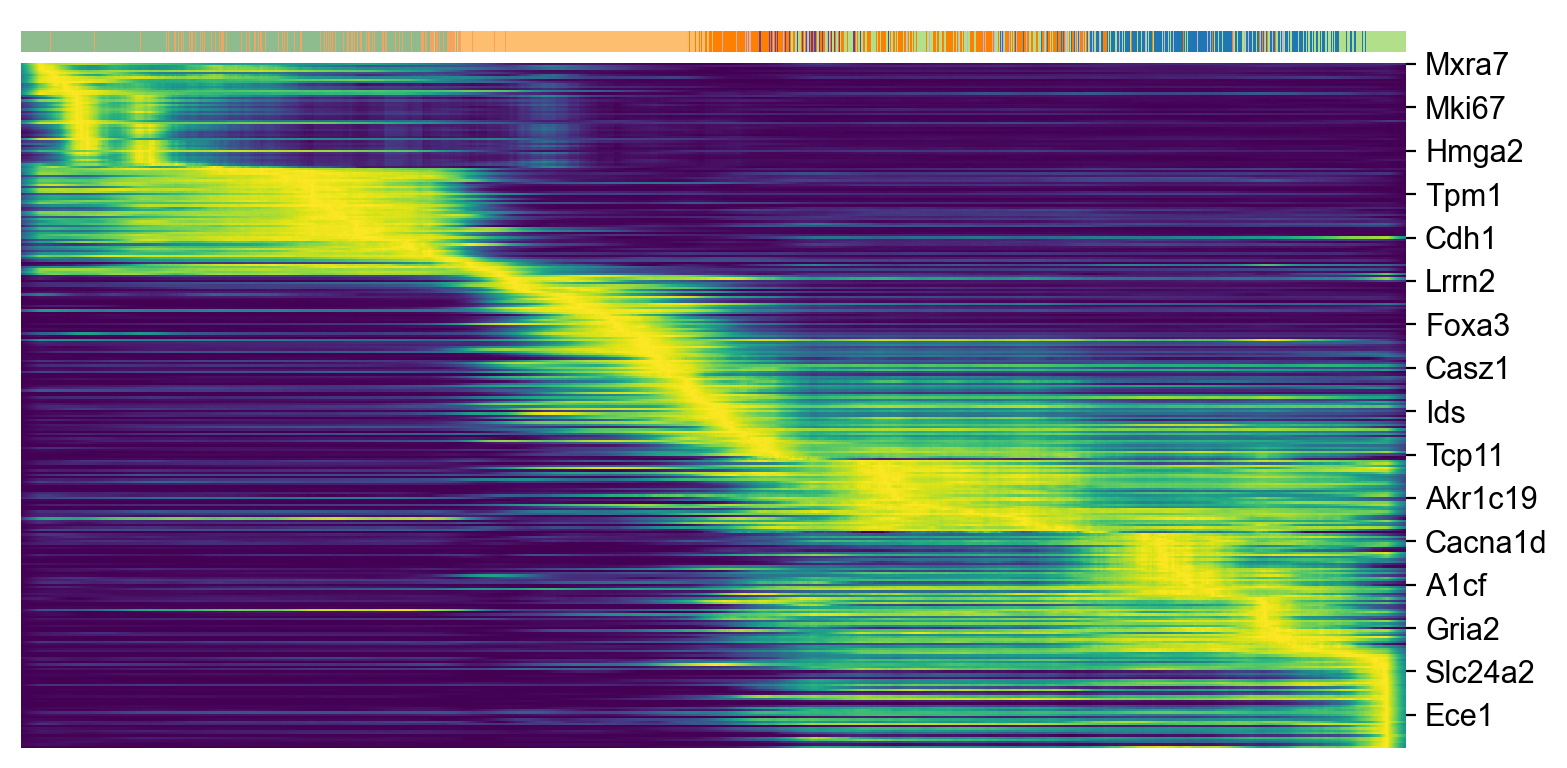

In [163]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

## Top-likelihood genes

Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

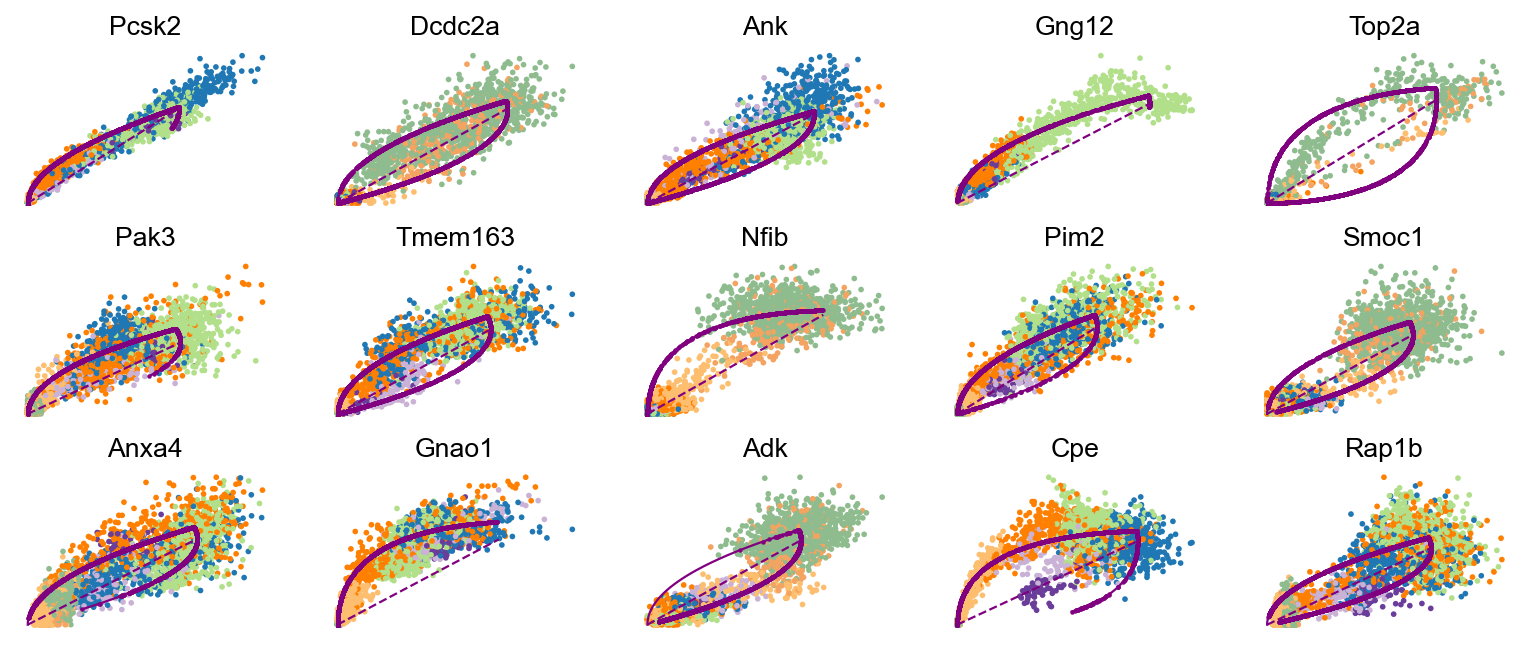

In [164]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

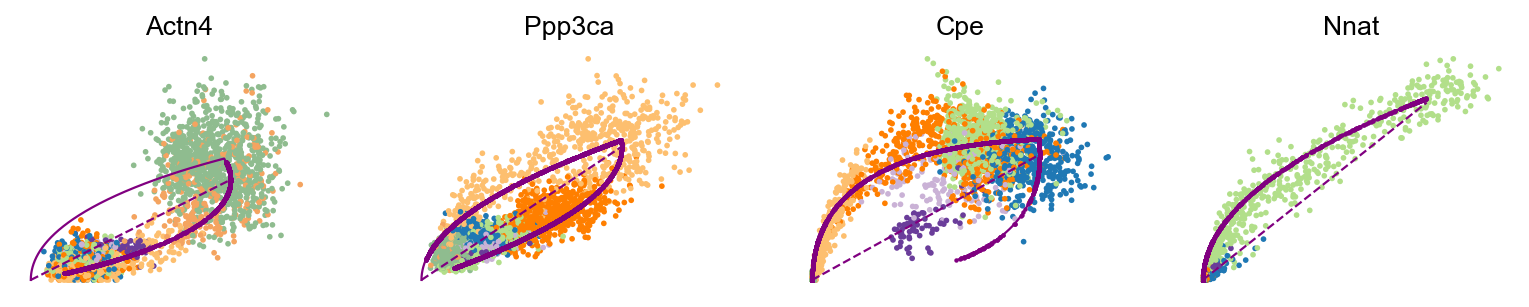

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

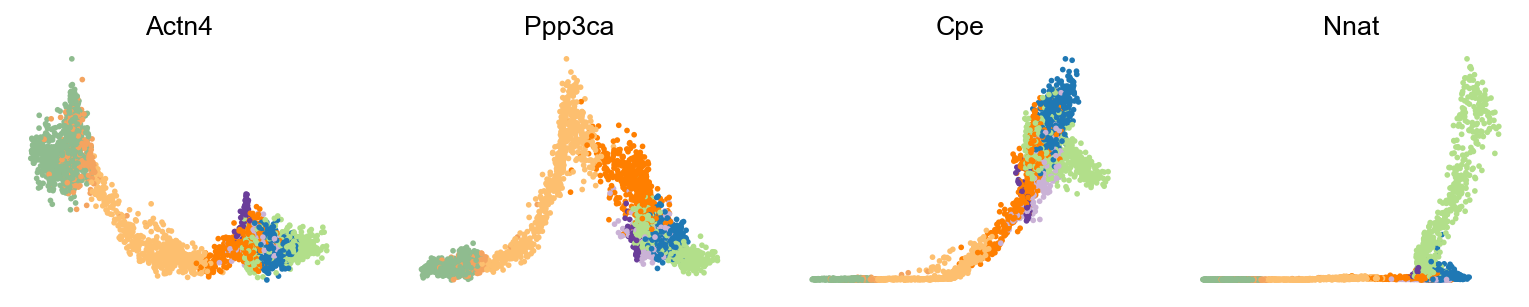

In [165]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

## Cluster-specific top-likelihood genes

Moreover, partial gene likelihoods can be computed for a each cluster of cells to enable cluster-specific identification of potential drivers.

In [166]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\core\_anndata.py:245: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(data.obs[key])


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta  Alpha   Delta  \
0   Dcdc2a      Dcdc2a       Rbfox3         Abcc8    Pcsk2    Cpe   Pcsk2   
1    Top2a         Adk       Mapre3       Tmem163      Ank  Gnao1   Rap1b   
2     Nfib       Mki67       Btbd17         Gnao1  Tmem163   Pak3    Pak3   
3  Wfdc15b    Rap1gap2        Sulf2           Ank   Tspan7   Pim2   Abcc8   
4     Cdk1       Top2a        Tcp11        Tspan7    Map1b  Map1b  Klhl32   

    Epsilon  
0      Tox3  
1    Rnf130  
2     Meis2  
3       Adk  
4  Rap1gap2

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

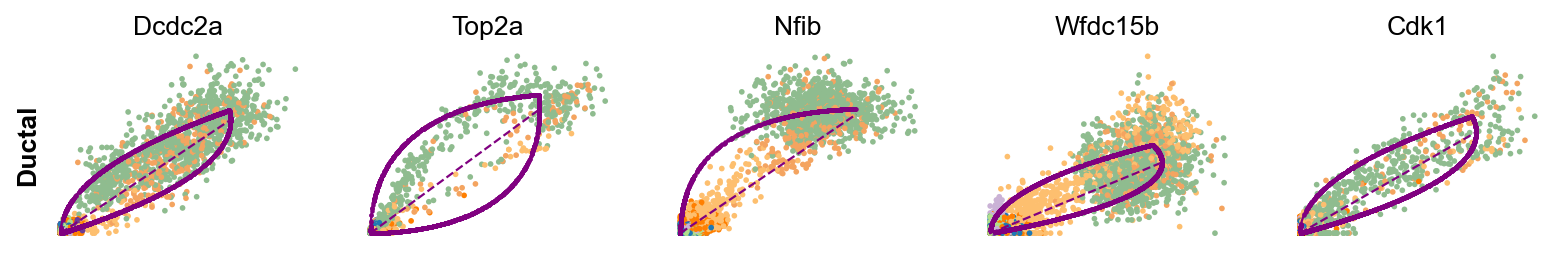

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

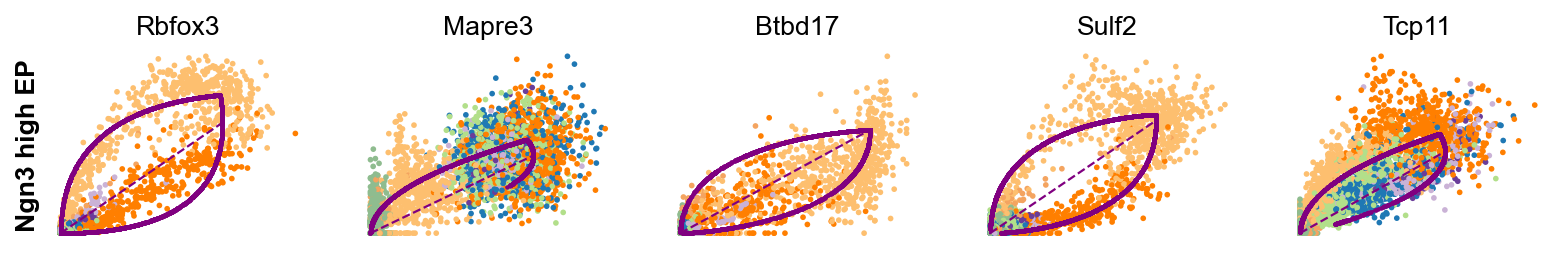

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

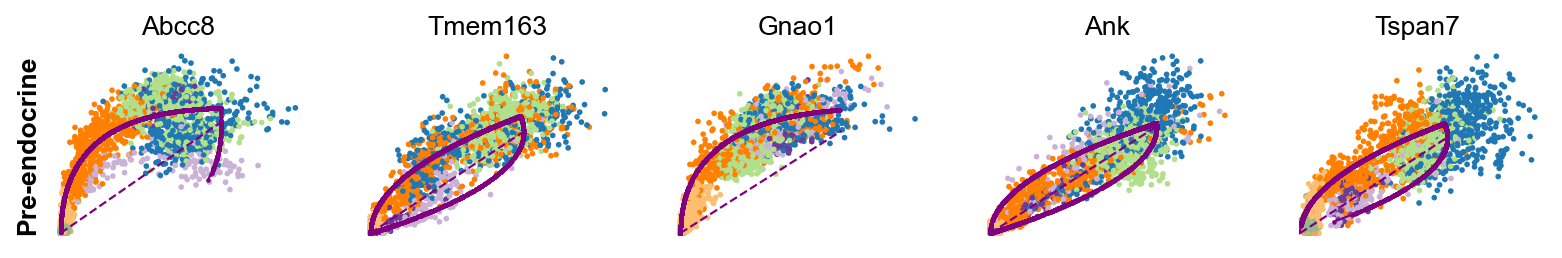

c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\zgx\anaconda3\envs\scanpy\lib\site-packages\scvelo\plotting\utils.py:63: Deprecati

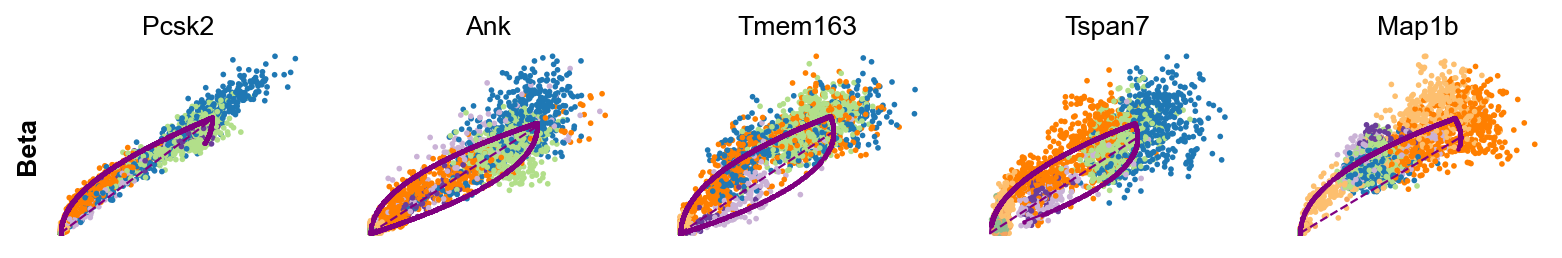

In [167]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)

## Reference


[1] Gioele La Manno, Ruslan Soldatov, Amit Zeisel, Emelie Braun, Hannah Hochgerner, Viktor Petukhov, Katja Lidschreiber, Maria E. Kastriti, Peter Lönnerberg, Alessandro Furlan, Jean Fan, Lars E. Borm, Zehua Liu, David van Bruggen, Jimin Guo, Xiaoling He, Roger Barker, Erik Sundström, Gonçalo Castelo-Branco, Patrick Cramer, Igor Adameyko, Sten Linnarsson, and Peter V. Kharchenko. RNA velocity of single cells. Nature, 560(7719):494–498, August 2018. URL: https://doi.org/10.1038/s41586-018-0414-6, doi:10.1038/s41586-018-0414-6.


[2] Volker Bergen, Marius Lange, Stefan Peidli, F. Alexander Wolf, and Fabian J. Theis. Generalizing RNA velocity to transient cell states through dynamical modeling. Nature Biotechnology, 38(12):1408–1414, August 2020. URL: https://doi.org/10.1038/s41587-020-0591-3, doi:10.1038/s41587-020-0591-3.